In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from utilities import read_xml, plot_two, plot_three
from neo4j import GraphDatabase
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier


In [95]:
# Import
PATH_DEV = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_dev.txt')
PATH_TEST = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_test.txt')
PATH_TRAIN = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_train.txt')

df_train = read_xml(PATH_TRAIN)
df_test = read_xml(PATH_TEST)
df_dev = read_xml(PATH_DEV)

frames = [df_train, df_test, df_dev]
df = pd.concat(frames).reset_index(drop=True)

# Basic Statistics


In [96]:
print('First 10 datasets')
df.head(10)

First 10 datasets


,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE
0,The New York Times Daily Crossword Puzzles: Th...,New York Times,"Dec 28, 1996",9780804115827,224 Pages,https://www.penguinrandomhouse.com/books/12309...,"Nonfiction, Games",(c) Penguin Random House,Monday’s Crosswords Do with EaseTuesday’s Cros...,2018-08-18,en
1,Creatures of the Night (Second Edition),Neil Gaiman,"Nov 29, 2016",9781506700250,48 Pages,https://www.penguinrandomhouse.com/books/53958...,"Fiction, Graphic Novels Manga",(c) Penguin Random House,Two of literary comics modern masters present ...,2018-08-18,en
2,Cornelia and the Audacious Escapades of the So...,Lesley M. M. Blume,"Jan 08, 2008",9780440421108,272 Pages,https://www.penguinrandomhouse.com/books/15160...,"Children’s Books, Children’s Middle Grade Books",(c) Penguin Random House,Eleven-year-old Cornelia is the daughter of tw...,2018-08-18,en
3,The Alchemist's Daughter,Katharine McMahon,"Oct 24, 2006",9780307335852,352 Pages,https://www.penguinrandomhouse.com/books/11223...,"Fiction, Historical Fiction",(c) Penguin Random House,"During the English Age of Reason, a woman cloi...",2018-08-18,en
4,Dangerous Boy,Mandy Hubbard,"Aug 30, 2012",9781101575017,272 Pages,https://www.penguinrandomhouse.com/books/30534...,"Teen Young Adult, Teen Young Adult Mystery ...",(c) Penguin Random House,A modern-day retelling of The Strange Case of ...,2018-08-18,en
5,Mystery Mother (Replica #8),Marilyn Kaye,"Sep 25, 2013",9780804149877,160 Pages,https://www.penguinrandomhouse.com/books/90521...,"Children’s Books, Children’s Middle Grade Books",(c) Penguin Random House,"Amy knows Nancy isn’t her birth mother, but sh...",2018-08-18,en
6,The Woman Who Wouldn't Die,Colin Cotterill,"Jan 07, 2014",9781616952976,320 Pages,https://www.penguinrandomhouse.com/books/22110...,"Crime Mysteries, Fiction, Mystery Suspense",(c) Penguin Random House,The long-awaited follow-up to 2011’s Slash Bu...,2018-08-18,en
7,The EC Archives: Two-Fisted Tales Volume 3,Various,"Aug 12, 2014",9781616552916,216 Pages,https://www.penguinrandomhouse.com/books/23998...,"Fiction, Graphic Novels Manga",(c) Penguin Random House,Before Two-Fisted Tales burst onto the scene i...,2018-08-18,en
8,The Complete Idiot's Guide to Intermediate Spa...,Steven Hawson,"Jun 05, 2007",9781440650550,400 Pages,https://www.penguinrandomhouse.com/books/35889...,"Language, Test Preparation, Nonfiction, Reference",(c) Penguin Random House,This revised edition offers expanded coverage ...,2018-08-18,en
9,Comic Sans Murder,Paige Shelton,"Dec 05, 2017",9780425277270,288 Pages,https://www.penguinrandomhouse.com/books/31713...,"Cozy Mysteries, Fiction, Mystery Suspense",(c) Penguin Random House,"Clare Henry’s snowy Star City, Utah, oasis tur...",2018-08-18,en


In [97]:
# Basic Statistic
print('Number of datasets: ', df.shape[0])
print('Number of columns: ', df.shape[1])
print('Columns: ', ', '.join(df.columns))

Number of datasets:  91894
Number of columns:  11
Columns:  TITLE, AUTHOR, PUBLISHED, ISBN, PAGE_NUM, URL, TOPICS, COPYRIGHT, DESCRIPTION, DATE, LANGUAGE


In [98]:
print('Columns: ', ', '.join(df.columns))
# Extracting Information
# Number of Authors, Copyright

# Number of Authors
print('Number of Authors: ', df['AUTHOR'].nunique())

# Number of Copyright
print('Number of Copyright: ', df['COPYRIGHT'].nunique())
print('Different Copyrights: ', df['COPYRIGHT'].unique())

# Number of Language
print('Number of Language: ', df['LANGUAGE'].nunique())
print('Different Langauge: ', df['LANGUAGE'].unique())

Columns:  TITLE, AUTHOR, PUBLISHED, ISBN, PAGE_NUM, URL, TOPICS, COPYRIGHT, DESCRIPTION, DATE, LANGUAGE
Number of Authors:  35928
Number of Copyright:  2
Different Copyrights:  ['(c) Penguin Random House' '(c) 2018 Penguin Random House']
Number of Language:  1
Different Langauge:  ['en']


In [99]:
# Extract Data
df['PAGE_NUM'] = df['PAGE_NUM'].str.extract('(\d+)').astype(int)    # Number of Pages
df['PUBLISHED'] = df['PUBLISHED'].str.extract(r'(\d{4})').astype(int)   # Publishing Year
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')    #
df['TOPIC_COUNT'] = df['TOPICS'].str.split(',').apply(lambda x: len(x))     # Number of Topics

In [100]:
df.describe()

,PUBLISHED,PAGE_NUM,DATE,TOPIC_COUNT
count,91894.000000,91894.000000,91894,91894.000000
mean,2008.610649,277.134655,2018-08-18 00:03:03.341676288,3.024060
min,1929.000000,1.000000,2018-08-18 00:00:00,1.000000
25%,2005.000000,160.000000,2018-08-18 00:00:00,2.000000
50%,2011.000000,272.000000,2018-08-18 00:00:00,3.000000
75%,2015.000000,352.000000,2018-08-18 00:00:00,4.000000
max,2019.000000,5392.000000,2018-09-26 00:00:00,11.000000
std,8.137799,201.229372,NaN,1.407657


Most common Authors: 
AUTHOR
DK                                 1022
Various                             445
Golden Books                        251
Louis L'Amour                       234
Random House                        234
DK Travel                           228
Tabor Evans                         200
Nora Roberts                        187
Jake Logan                          184
Jon Sharpe                          164
Dr. Seuss                           159
William Shakespeare                 159
RH Disney                           159
Princeton Review                    157
Wesley Ellis                        152
Living Language                     149
National Geographic Kids            144
David A. Adler                      122
Danielle Steel                      119
Bonnie Bryant                       111
Nancy Krulik                        107
Roger Hargreaves                    105
Robert B. Parker                    103
Gary Paulsen                        100
Jim Davis  

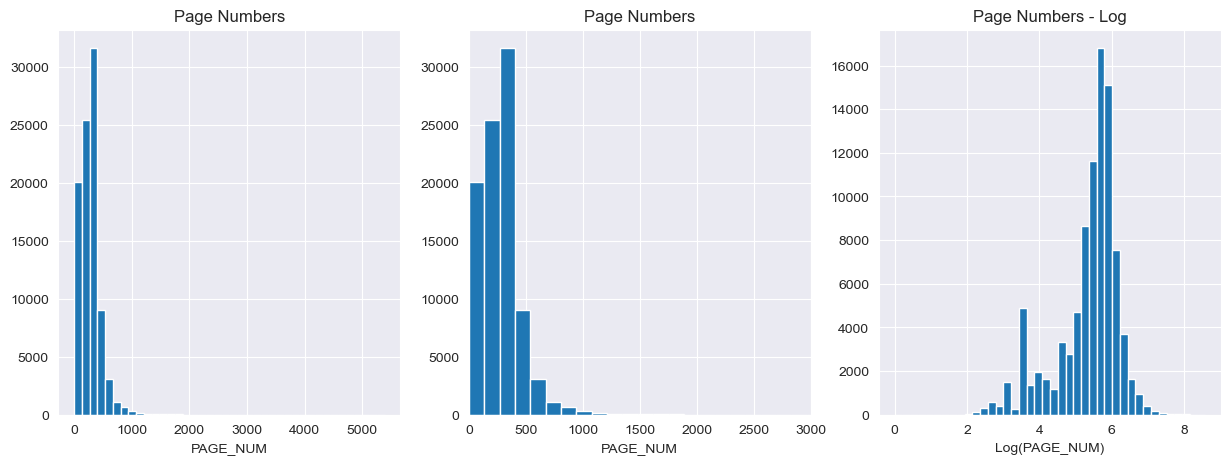

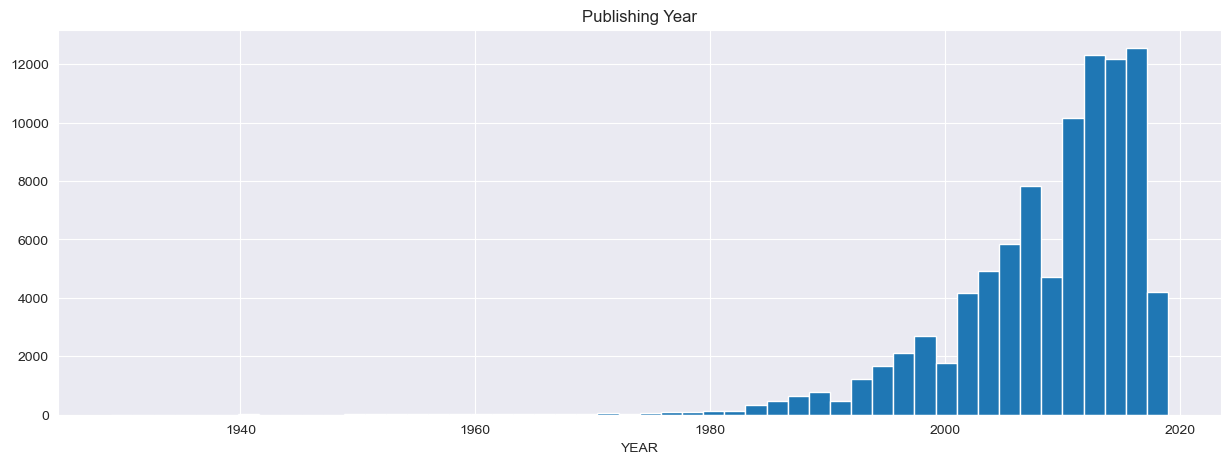

In [101]:
# Histogramm - Page Numbers
plot_three(data=df['PAGE_NUM'], title='Page Numbers', bins=40,  xlabel='PAGE_NUM', xlim=3000)

# Histogramm - Published Year
plt.figure(figsize=(15, 5))
plt.hist(df['PUBLISHED'], bins=50)
plt.title('Publishing Year')
plt.xlabel('YEAR')

# Authors
# Print 10 most common Authors
print('Most common Authors: ')
print(df['AUTHOR'].value_counts().head(50))

print('Number of Books without an Author: ', df.isnull().sum())

# Exploring Topics

In [102]:
df['TOPICS_SPLIT'] = df['TOPICS'].apply(lambda x: sorted(list(set(i.strip() for i in re.split(r'[,\s]{2,}', x)))))

single_topic_df = df[df['TOPIC_COUNT'] == 1]
print('All topics that appear individually in books:', ', '.join(single_topic_df['TOPICS'].unique()))


All topics that appear individually in books: Fiction, Children’s Books, Nonfiction, Poetry, Humor, Classics


In [103]:
print(f'\nBook with most Topics:')
df.sort_values(by='TOPIC_COUNT', ascending=False).head(10)


Book with most Topics:


,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE,TOPIC_COUNT,TOPICS_SPLIT
23873,Travels with a Donkey in the Cevennes and the ...,Robert Louis Stevenson,2005,9780141439464,320,https://www.penguinrandomhouse.com/books/28630...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"In 1878, Robert Louis Stevenson was suffering ...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
1288,Pictures from Italy,Charles Dickens,1998,9780140434316,272,https://www.penguinrandomhouse.com/books/26095...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,A delightful travelogue in the unique style of...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
76498,Italian Hours,Henry James,1995,9780140435078,416,https://www.penguinrandomhouse.com/books/29650...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"“The charm of certain vacant grassy spaces, in...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
21285,A Tramp Abroad,Mark Twain,1997,9780140436082,448,https://www.penguinrandomhouse.com/books/29654...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,"Twain’s account of travelling in Europe, A TRA...",2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
89464,D. H. Lawrence and Italy,D. H. Lawrence,2008,9780141441559,528,https://www.penguinrandomhouse.com/books/32292...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,In these impressions of the Italian countrysid...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
6833,A Russian Journal,John Steinbeck,1999,9780141180199,240,https://www.penguinrandomhouse.com/books/35425...,"World History, Travel Writing, Literary Figure...",(c) Penguin Random House,Steinbeck and Capa’s account of their journey ...,2018-08-18,en,11,"[Arts, Biography, Classics, Entertainment Biog..."
23250,The World of Debbie Macomber: Come Home to Color,Debbie Macomber,2016,9780425286074,96,https://www.penguinrandomhouse.com/books/54610...,"Personal Growth, Art, Inspiration Motivation,...",(c) Penguin Random House,From beloved author and Hallmark Channel favor...,2018-08-18,en,9,"[Art, Arts, Crafts, Entertainment, Garden, Hob..."
61581,The Friendly Jane Austen,Natalie Tyler,2001,9781101191538,320,https://www.penguinrandomhouse.com/books/33169...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,What’s so friendly about Jane Austen?Every gen...,2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."
7400,Saint-exupery,Stacy Schiff,2011,9780307798398,522,https://www.penguinrandomhouse.com/books/16186...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,"From a master biographer, the life story of th...",2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."
22334,James Joyce,Edna O'Brien,1999,9781415910580,360,https://www.penguinrandomhouse.com/books/12315...,"World History, Literary Figure Biographies Me...",(c) Penguin Random House,One of Ireland’s best current novelists provid...,2018-08-18,en,9,"[Arts, Biography, Classics, Entertainment Biog..."


Worldcloud of all the Topics


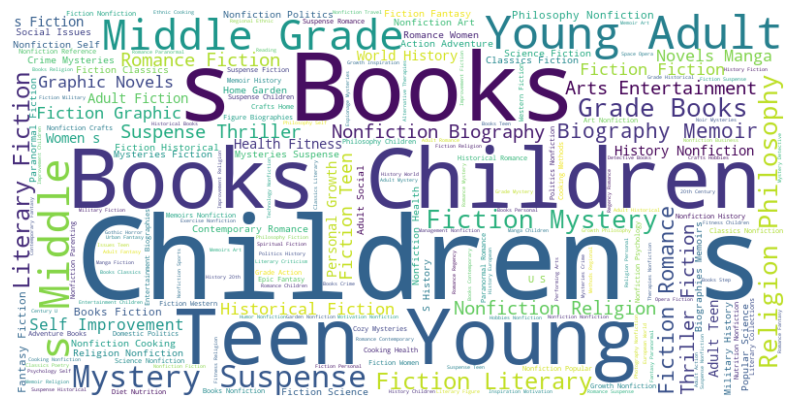


10 Most Common Topics: 
                           TOPICS  COUNT
1                      Nonfiction  34270
2                         Fiction  32812
5                Children’s Books  19792
8                        Suspense   9386
15                        Mystery   8856
6   Children’s Middle Grade Books   7728
32               Literary Fiction   7378
29                       Religion   7145
28                     Philosophy   7145
24                        Romance   6429

10 Least Common Topics: 

Count Different Topics: 166
                           TOPICS  COUNT
150  World War I Military History     28
153               Travel: Central     17
152                 South America     17
162           Travel: Middle East     17
160                        Mexico     14
161             Travel: Caribbean     14
165                Travel: Africa     14
157                        Bibles      5
163                       Oceania      5
164             Travel: Australia      5


In [104]:
all_topics = df['TOPICS_SPLIT'].explode().str.strip()
topic_counts = Counter(all_topics)
dftopics = pd.DataFrame(topic_counts.items(), columns=['TOPICS', 'COUNT']).sort_values(by='COUNT', ascending=False)

# Wordcloud
print('Worldcloud of all the Topics')
text = " ".join(df['TOPICS'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
print(f'\n10 Most Common Topics: ')
print(dftopics.head(10))
print(f'\n10 Least Common Topics: ')

print()
print(f'Count Different Topics: {dftopics.shape[0]}')
print(dftopics.tail(10))

# Exploring Blurbs

In [105]:
print('First 10 Blurbs:')
for val in df['DESCRIPTION'][0:10]:
    print(val)
    print('-------------------')

First 10 Blurbs:
Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential to each day as the first cup of coffee in the morning. Now, for the first time ever, these premier puzzles are available in six clever installments. With each day of the week, the puzzles increase gradually in skill level; Monday’s the easiest, but Saturday’s sure to challenge! Push your mental muscles a little harder each day with America’s favorite sophisticated — and fun — pastime: the New York Times crossword puzzles!The legendary Eugene T. Maleska was crossword editor of The New York Times from 1977 to 1993.
-------------------
Two of literary comics modern masters present a pair of magical and disturbing stories of strange creatures who are not quite what they seem! In The

Findings:
* It looks like \t \n \r are missing. In the first book blurb we can see it at 'EaseTuesday’, 'StillThursday'
* Blurbs often include information of the author, book version (hardcopy,...)

In [116]:
# Clean Errors in Description
dfb = df[['DESCRIPTION']].copy()

def clean_description(text):
    # Remove whitespace between .,;!?
    text = re.sub(r'(\S)\s*(?=[.,;!?])', r'\1', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove extra Punctuations
    text = re.sub(r'\.{2,}', '.', text)
    # Insert Whitespace after .,;!? if missing
    text= re.sub(r'([.,;!?])(?=\S)', r'\1 ', text)
    # Split concatenated words --> EasyTuesday -> Easy. Tuesday
    text = re.sub(r'(?<=[a-z])(?=[A-Z])(?=[a-zA-Z])', '. ', text)

    return text

# Apply cleaning
dfb['DESCRIPTION'] = dfb['DESCRIPTION'].fillna('').apply(clean_description)
print('First Blurb after description cleaning:')
print(dfb['DESCRIPTION'][0])

First Blurb after description cleaning:
Monday’s Crosswords Do with Ease. Tuesday’s Crosswords Not a Breeze. Wednesday’s Crosswords Harder Still. Thursday’s Crosswords Take Real Skill. Friday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star! For millions of people, the New York Times crossword puzzles are as essential to each day as the first cup of coffee in the morning. Now, for the first time ever, these premier puzzles are available in six clever installments. With each day of the week, the puzzles increase gradually in skill level; Monday’s the easiest, but Saturday’s sure to challenge! Push your mental muscles a little harder each day with America’s favorite sophisticated — and fun — pastime: the New York Times crossword puzzles! The legendary Eugene T. Maleska was crossword editor of The New York Times from 1977 to 1993.


In [117]:
dfb['DESCRIPTION_LOWER'] = dfb['DESCRIPTION'].str.lower()
dfb['DESCRIPTION_SPLIT'] = dfb['DESCRIPTION_LOWER'].str.split()
dfb['WORD_COUNT'] = dfb['DESCRIPTION_SPLIT'].apply(len)
dfb['SENTENCE_COUNT'] = dfb['DESCRIPTION'].str.count('\.') + dfb['DESCRIPTION'].str.count('\!') + dfb['DESCRIPTION'].str.count('\?')

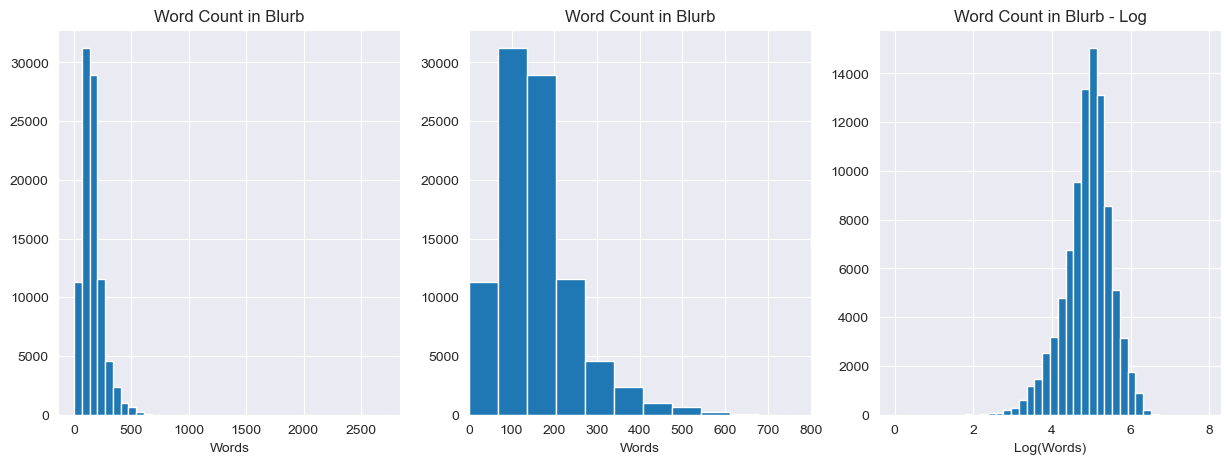

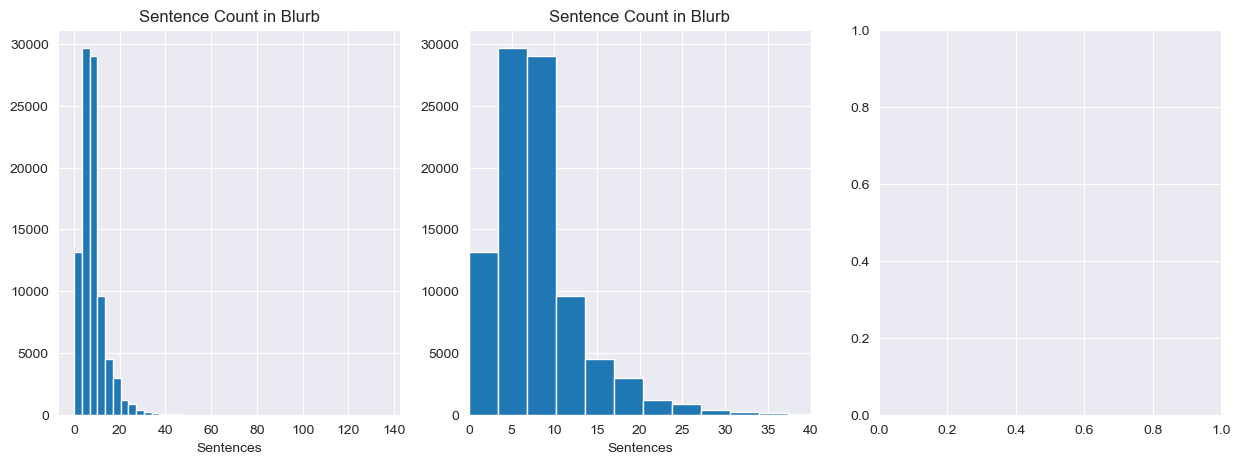

In [118]:
# Histogram Word COunt
plot_three(data=dfb['WORD_COUNT'], title='Word Count in Blurb', bins=40,  xlabel='Words', xlim=800)

# Histogram Sentence Count
plot_two(data=dfb['SENTENCE_COUNT'], title='Sentence Count in Blurb', bins=40,  xlabel='Sentences', xlim=40)

In [119]:
# Longest Blurb
print('Longest Blurb:')
print(dfb.loc[dfb['SENTENCE_COUNT'].idxmax(), 'DESCRIPTION'])

Longest Blurb:
Exercise: How Connected Are Your Kids? There are lots of questions you can ask yourself if you want to know just how connected your child is. Below, I’ve listed a few that are adapted from questionnaires that are given to children to assess their capacity for citizenship and their ability to participate in their communities and make a positive contribution. Thinking about your child, answer the following questions. There is no perfect profile, no wunderkind who will impress everyone. But in beginning to think about your child as a responsible member of not only your family but also in his school and community, we need to first consider his or her strengths. Every child has a unique pattern to how he or she handles conflict and responsibility. Our goal as parents should be to edge our children towards more responsible, compassionate behaviour. Section One: Life at Home1. If your child wants something done his/her way, does your child:a. Insist and argue, but never comprom

## Cluster Labels

146 Labels are to much for classification.
Trying out different clustering methods to reduce number of labels

### By Least Common Multiple (Kleinstes Gemeinsames Vielfaches)

Finding the smallest number of labels so that still every book has at least one label

In [121]:
# Find a minimum list of topics to cover all books
single_topic_df = df[df['TOPIC_COUNT'] == 1]
multi_topic_df = df[df['TOPIC_COUNT'] > 1]
single_topic_list = list(single_topic_df['TOPICS'].unique())+['Young Adult']
topics_in_multi = multi_topic_df[multi_topic_df['TOPICS_SPLIT'].apply(lambda x: not any(topic in x for topic  in single_topic_list))]
if topics_in_multi.empty:
    print('All books can be covered by the topics: ', ', '.join(single_topic_list))
else:
    print(topics_in_multi)

# ALl Books that have more than one of this topics
print('\nBooks with more then one of this topics: ')
mmulti_topic_df = df[df['TOPICS_SPLIT'].apply(lambda x: sum(topic in x for topic  in single_topic_list)>1)]
mmulti_topic_df

All books can be covered by the topics:  Fiction, Children’s Books, Nonfiction, Poetry, Humor, Classics, Young Adult

Books with more then one of this topics: 


,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE,TOPIC_COUNT,TOPICS_SPLIT
29,The BAP Handbook,"Ginger Wilson, Kalyn Johnson, Tracey Lewis, Ka...",2001,9780767905503,224,https://www.penguinrandomhouse.com/books/19187...,"Humor, Nonfiction, Reference",(c) Penguin Random House,"""Finally, a book about the Black American Prin...",2018-08-18,en,3,"[Humor, Nonfiction, Reference]"
35,Storyteller,Leslie Marmon Silko,2012,9780143121282,288,https://www.penguinrandomhouse.com/books/31015...,"Poetry, Fiction",(c) Penguin Random House,Now back in print—a classic work of Native Ame...,2018-08-18,en,2,"[Fiction, Poetry]"
51,The Complete Poems,John Keats,1977,9780140422108,752,https://www.penguinrandomhouse.com/books/26104...,"Classics, Poetry, Literary Collections",(c) Penguin Random House,The complete poems of an English masterKeats’s...,2018-08-18,en,3,"[Classics, Literary Collections, Poetry]"
56,Sensual Love Poems,Kathleen Blease,2002,9780345447876,176,https://www.penguinrandomhouse.com/books/14823...,"Classics, Poetry, Literary Criticism",(c) Penguin Random House,How does love speak? . . . In the embrace wher...,2018-08-18,en,3,"[Classics, Literary Criticism, Poetry]"
60,Archie Archives Volume 12,Various,2016,9781616557058,232,https://www.penguinrandomhouse.com/books/53717...,"Humor, Fiction, Graphic Novels Manga",(c) Penguin Random House,"If there’s trouble, Archie’s usually in the mi...",2018-08-18,en,3,"[Fiction, Graphic Novels, Humor, Manga]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91808,Be Sweet,"Roy Blount, Jr.",2013,9780307829719,288,https://www.penguinrandomhouse.com/books/15063...,"Literary Figure Biographies Memoirs, Arts En...",(c) Penguin Random House,In the book his laughing and loving readers ha...,2018-08-18,en,5,"[Arts, Biography, Entertainment Biographies, H..."
91816,Expensive People,Joyce Carol Oates,2006,9780812976540,256,https://www.penguinrandomhouse.com/books/12387...,"Classics, Fiction, Literary Fiction, Fiction C...",(c) Penguin Random House,Joyce Carol Oates’s Wonderland Quartet compris...,2018-08-18,en,5,"[Classics, Fiction, Fiction Classics, Historic..."
91862,Selected Poems,Pierre Ronsard,2002,9780140424249,384,https://www.penguinrandomhouse.com/books/27840...,"Classics, Poetry, Literary Collections",(c) Penguin Random House,Ronsard is considered one of France’s greatest...,2018-08-18,en,3,"[Classics, Literary Collections, Poetry]"
91868,Falling Into Place,Catherine Reid,2015,9780807061183,182,https://www.penguinrandomhouse.com/books/22672...,"Science, Classics, Nonfiction, Literary Collec...",(c) Penguin Random House,"Quietly powerful essays, weaving keenly observ...",2018-08-18,en,5,"[Classics, Literary Collections, Nonfiction, P..."


## Cluster Labels - Trying ML Methods

KMean and Agglomertive Clustering.

Embedding was done with the pretrained SBERT-Model.

In [123]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
os.environ['OMP_NUM_THREADS'] = '1'

# Load pretrained SBERT-Model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Embedding for every Topic
embeddings = model.encode(dftopics['TOPICS'].tolist())


for num_clusters in (15, 20):
    # KMeans-Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    dftopics['CLUSTER_KMEANS'] = kmeans.fit_predict(embeddings)
    clustered_topics = dftopics.groupby('CLUSTER_KMEANS')['TOPICS'].apply(list)
    print(f'\n\nkMeans Clustering - {num_clusters} Cluster')
    for cluster, topics in clustered_topics.items():
        print(f"Cluster {cluster}: {topics}")

    # Agglomerative Clustering
    agglom = AgglomerativeClustering(n_clusters=num_clusters, metric='cosine', linkage='average')
    dftopics['CLUSTER_AGG'] = agglom.fit_predict(embeddings)
    clustered_topics = dftopics.groupby('CLUSTER_AGG')['TOPICS'].apply(list)
    print(f'\n\nAgglomerative Clustering - {num_clusters} Cluster')
    for cluster, topics in clustered_topics.items():
        print(f"Cluster {cluster}: {topics}")



kMeans Clustering - 15 Cluster
Cluster 0: ['Suspense', 'Romance', 'Thriller', 'Contemporary Romance', 'Historical Romance', 'Suspense Romance', 'Paranormal Romance', 'Young Adult Romance', 'Regency Romance', 'Western Romance', 'New Adult Romance', 'Weddings']
Cluster 1: ['Travel', 'Travel: Europe', 'Travel Writing', 'Travel: USA', 'Specialty Travel', 'Travel: Asia', 'Travel: Central', 'Travel: Middle East', 'Travel: Caribbean', 'Travel: Africa', 'Travel: Australia']
Cluster 2: ['History', 'World History', 'U.S. History', 'Military History', 'European World History', 'Regional', '20th Century U.S. History', 'World War II Military History', '1950 – Present Military History', 'Asian World History', 'Canada', 'Colonial/Revolutionary Period', 'Middle Eastern World History', '19th Century U.S. History', 'Civil War Period', '21st Century U.S. History', 'Ancient World History', 'North American World History', 'Latin American World History', 'African World History', 'Native American History',

C:\Users\Romina\anaconda3\envs\fff\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Romina\anaconda3\envs\fff\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Ergebnis ist nicht so schlecht -> Analyse

## Additional Data Exploration

Try Universal Sentence Encoder - https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded

In [ ]:
descriptions = df['DESCRIPTION'].tolist()

def batch_embed(model, texts, batch_size=512):
    embeddings_list = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_embeddings = model(batch)
        embeddings_list.append(batch_embeddings.numpy())
        print(f"Processed batch {i // batch_size + 1} of {((len(texts)-1)//batch_size)+1}")
    return np.vstack(embeddings_list)

embeddings_np = batch_embed(model, descriptions, batch_size=512)
df['embeddings'] = list(embeddings_np)
print("Embeddings shape:", embeddings_np.shape)

In [ ]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)

plt.figure(figsize=(11, 6))
plt.title('Embedding space')
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10)
nn.fit(embeddings_np)

def recommend_book(text):
    emb = embed([text])
    neighbors = nn.kneighbors(emb, return_distance=False)[0]
    return df['TITLE'].iloc[neighbors].tolist()

In [ ]:
print('Top 10 similar books based on description:')
recommend_book("The New York Times Daily Crossword Puzzles: Thursday, Volume 1")

In [ ]:
df.info()

In [ ]:
def plot_similarity(messages):
    message_embeddings = embed(messages)

    corr = np.inner(message_embeddings, message_embeddings)

    sns.heatmap(
        corr,
        xticklabels=[label[:30] for label in messages],
        yticklabels=[label[:30] for label in messages],
        annot=True,
        fmt=".2f"
    ).set_title("Semantic Textual Similarity")

messages = [
    df['DESCRIPTION'].iloc[0],
    df['DESCRIPTION'].iloc[1],
    df['DESCRIPTION'].iloc[2],
    df['DESCRIPTION'].iloc[3],
]

plot_similarity(messages)

In [ ]:
topic_embeddings = {}

for topic in unique_topics:
    topic_rows = df[df['TOPICS_SPLIT'].apply(lambda x: topic in x)]

    topic_embeddings_list = topic_rows['embeddings'].tolist()
    topic_embeddings_np = np.array([embedding for embedding in topic_embeddings_list])

    topic_mean_embedding = np.mean(topic_embeddings_np, axis=0)

    topic_embeddings[topic] = topic_mean_embedding

topic_df = pd.DataFrame(topic_embeddings.items(), columns=['Topic', 'Embedding'])

In [ ]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE

topics = list(topic_embeddings.keys())
embeddings = np.array(list(topic_embeddings.values()))

# 1. **PCA** - Reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 2. **t-SNE** - Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

def plot_interactive_scatter(x, y, title):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='markers',
        marker=dict(size=10, opacity=0.7),
        text=topics,  # Labels for points
        hoverinfo="text",  # Show label on hover
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        template="plotly_white",
        hovermode="closest"  # Shows only the closest point label
    )

    fig.show()

plot_interactive_scatter(pca_result[:, 0], pca_result[:, 1], "PCA of Topic Embeddings")
plot_interactive_scatter(tsne_result[:, 0], tsne_result[:, 1], "t-SNE of Topic Embeddings")

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.figure_factory as ff
embeddings = np.stack(topic_df['Embedding'].to_numpy())
labels = topic_df['Topic'].tolist()

Z = linkage(embeddings, method='ward')
print("Linkage matrix shape:", Z.shape)

fig = ff.create_dendrogram(
    embeddings,
    orientation='left',
    labels=labels,
    linkagefun=lambda x: Z  # Use the precomputed linkage matrix.
)

fig.update_layout(
    title="Dendrogram of Topic Embeddings",
    xaxis_title="Distance",
    yaxis_title="Topic",
    width=800,
    height=600
)

fig.show()

In [ ]:
n_clusters = 146 # does not work
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)
df['cluster'] = clusters
print(df[['TITLE', 'cluster']])

In [ ]:
df[df['cluster'] == 1]

Try
NLTK: https: // www.nltk.org /

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')

In [ ]:
print(set(stopwords.words('english')))

In [ ]:
data = "Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential to each day as the first cup of coffee in the morning. Now, for the first time ever, these premier puzzles are available in six clever installments. With each day of the week, the puzzles increase gradually in skill level; Monday’s the easiest, but Saturday’s sure to challenge! Push your mental muscles a little harder each day with America’s favorite sophisticated — and fun — pastime: the New York Times crossword puzzles!The legendary Eugene T. Maleska was crossword editor of The New York Times from 1977 to 1993."
stopWords = set(stopwords.words('english'))
words = word_tokenize(data)
wordsFiltered_nltk = [w for w in words if w not in stopWords]

print(wordsFiltered_nltk)

Try
spacy: https: // spacy.io / usage

In [ ]:
import spacy

# spacy.cli.download("en_core_web_sm") # download once
nlp = spacy.load("en_core_web_sm")

In [ ]:
print(set(nlp.Defaults.stop_words))

In [ ]:
nltk_stopwords = set(stopwords.words('english'))
spacy_stopwords = set(nlp.Defaults.stop_words)

nlp_not_in_nltk = spacy_stopwords - nltk_stopwords  # SpaCy stopwords not in NLTK
nltk_not_in_nlp = nltk_stopwords - spacy_stopwords  # NLTK stopwords not in SpaCy
common_stopwords = nltk_stopwords & spacy_stopwords  # Common stopwords

print("Stopwords in NLTK but not in SpaCy:", sorted(nltk_not_in_nlp))
print("Stopwords in SpaCy but not in NLTK:", sorted(nlp_not_in_nltk))
print("Common stopwords:", sorted(common_stopwords))

In [ ]:
doc = nlp(
    "Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential to each day as the first cup of coffee in the morning. Now, for the first time ever, these premier puzzles are available in six clever installments. With each day of the week, the puzzles increase gradually in skill level; Monday’s the easiest, but Saturday’s sure to challenge! Push your mental muscles a little harder each day with America’s favorite sophisticated — and fun — pastime: the New York Times crossword puzzles!The legendary Eugene T. Maleska was crossword editor of The New York Times from 1977 to 1993.")

stopWords = set(nlp.Defaults.stop_words)
wordsFiltered_spacy = [w.text for w in doc if w.text.lower not in stopWords]
print(wordsFiltered_spacy)

Clean ** Description ** by
lowercasing + remove
special
characters

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # only keep a-z + whitespaces
    text = re.sub(r'\s+', ' ', text).strip()  # remove consecutive whitespaces + leading/trailing
    return text


df['clean_description'] = df['DESCRIPTION'].astype(str).apply(clean_text)
df[['DESCRIPTION', 'clean_description']].head()

Tokenize ** Description ** + remove
stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens


df['tokens'] = df['clean_description'].apply(tokenize_text)
df[['clean_description', 'tokens']].head()

Vectorize using TF - IDF(maybe use something different later - word2vec)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')  # english stopwords ignored
X = vectorizer.fit_transform(df['clean_description'])

print("TF-IDF matrix shape:", X.shape)
# 91894 book descriptions
# 343357 vocabulary size

Try
Neo4j

In [ ]:
from neo4j import GraphDatabase
import requests

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "neo4jtest1"))

try:
    response = requests.get("http://localhost:7474")
    if response.status_code != 200:
        raise SystemExit(f"Neo4j is unreachable. HTTP Status Code: {response.status_code}")
    else:
        print("Neo4j is up and reachable!")
except requests.exceptions.RequestException as e:
    raise SystemExit(f"ERROR: Could not reach Neo4j. Reason: {e}")


def create_topic_node(tx, topic, embedding):
    query = (
        "MERGE (t:Topic {name: $topic}) "
        "SET t.embedding = $embedding"
    )
    tx.run(query, topic=topic, embedding=embedding.tolist())


with driver.session() as session:
    for _, row in topic_df.iterrows():
        session.execute_write(create_topic_node, row['Topic'], row['Embedding'])

print("Topic nodes have been created in Neo4j.")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embeddings_matrix = np.vstack(topic_df['Embedding'].values)
similarity_matrix = cosine_similarity(embeddings_matrix)

thresholds = {
    "SIMILAR_TO_80": (0.8, 0.85),
    "SIMILAR_TO_85": (0.85, 0.9),
    "SIMILAR_TO_90": (0.9, 0.95),
    "SIMILAR_TO_95": (0.95, 1.0)
}

topic_names = topic_df['Topic'].tolist()

# dictionary to hold relationships for each threshold bucket
relationships_buckets = {
    "SIMILAR_TO_80": [],
    "SIMILAR_TO_85": [],
    "SIMILAR_TO_90": [],
    "SIMILAR_TO_95": []
}

for i in range(len(topic_names)):
    for j in range(i + 1, len(topic_names)):
        sim = similarity_matrix[i, j]
        # Only consider pairs with similarity >= 0.8
        if sim >= 0.8:
            # Check each bucket + assign accordingly
            for rel_type, (low, high) in thresholds.items():
                if low <= sim < high:
                    relationships_buckets[rel_type].append((topic_names[i], topic_names[j], sim))
                    break  # once found, no need to check further

for rel_type, rel_list in relationships_buckets.items():
    print(f"Number of relationships for {rel_type}: {len(rel_list)}")

In [ ]:
# Clear existing relationships for testing different thresholds
def delete_similar_to_if_exists():
    with driver.session() as session:
        # Check if any SIMILAR_TO relationships exist
        query_check = "MATCH ()-[r:SIMILAR_TO]-() RETURN COUNT(r) AS count"
        count = session.execute_read(lambda tx: tx.run(query_check).single()["count"])

        if count > 0:
            session.execute_write(lambda tx: tx.run("MATCH ()-[r:SIMILAR_TO]-() DELETE r"))
            print(f"Deleted {count} existing SIMILAR_TO relationships.")
        else:
            print("No SIMILAR_TO relationships found. Nothing to delete.")


In [ ]:

def create_similarity_relationship(tx, topic1, topic2, similarity):
    query = (
        "MATCH (a:Topic {name: $topic1}), (b:Topic {name: $topic2}) "
        "MERGE (a)-[r:SIMILAR_TO]->(b) "
        "SET r.similarity = $similarity"
    )
    tx.run(query, topic1=topic1, topic2=topic2, similarity=similarity)


# Clear existing relationship
delete_similar_to_if_exists()

with driver.session() as session:
    for topic1, topic2, sim in relationships_buckets["SIMILAR_TO_90"]:
        session.execute_write(create_similarity_relationship, topic1, topic2, sim)

print("SIMILAR_TO relationships have been created in Neo4j.")

In [ ]:
def query_current_threshold(threshold_key):
    low, high = thresholds[threshold_key]
    with driver.session() as session:
        query = (
            "MATCH (a:Topic)-[r:SIMILAR_TO]->(b:Topic) "
            "WHERE r.similarity >= $low AND r.similarity < $high "
            "RETURN a.name AS TopicA, b.name AS TopicB, r.similarity AS Similarity"
        )
        result = session.execute_read(lambda tx: list(tx.run(query, low=low, high=high)))
        return result


threshold_key = "SIMILAR_TO_80"
print(
    f"\nQuery Results for {threshold_key} (Threshold: {thresholds[threshold_key][0]} to {thresholds[threshold_key][1]}):")
results = query_current_threshold(threshold_key)
for record in results:
    print(record)

In [ ]:
driver.close()

In [ ]:
# Stimmt Topic mit Description überein?